### Instructor Demo: Stock Portfolio Forecasting

This program executes `1000` simulations of stock price trajectory for `JNJ` and `MU` over the next `252` trading days (or year of trading), based on a normal probability distribution of potential daily returns derived from the corresponding sample means and standard deviations. Daily and cumulative portfolio returns are then calculated, using `60%` of capital allocated to `JNJ` and `40%` of capital allocated to `MU`, to analyze the probability distribution and confidence interval of potential ending cumulative portfolio returns.

In [1]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

In [2]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

### Check Available Tickers from Alpaca Markets API

In [3]:
# Get all Assets
assets = api.list_assets()

# Keep only tradeable assets
tradeable = [asset for asset in assets if asset.tradable ]
tradeable

[Asset({   'class': 'us_equity',
     'easy_to_borrow': False,
     'exchange': 'NASDAQ',
     'id': '2a5db6a2-c035-46cc-840f-fa519740a9b5',
     'marginable': True,
     'name': 'LifeSci Acquisition Corp. Common Stock',
     'shortable': False,
     'status': 'active',
     'symbol': 'LSAC',
     'tradable': True}),
 Asset({   'class': 'us_equity',
     'easy_to_borrow': True,
     'exchange': 'NYSE',
     'id': '49b90cdc-f6f5-4a7c-807a-ed172e6017af',
     'marginable': True,
     'name': 'American Express Company',
     'shortable': True,
     'status': 'active',
     'symbol': 'AXP',
     'tradable': True}),
 Asset({   'class': 'us_equity',
     'easy_to_borrow': True,
     'exchange': 'NYSE',
     'id': 'f85c0ede-3556-4d0b-9e0c-4ffc2425044d',
     'marginable': True,
     'name': 'Diageo plc',
     'shortable': True,
     'status': 'active',
     'symbol': 'DEO',
     'tradable': True}),
 Asset({   'class': 'us_equity',
     'easy_to_borrow': False,
     'exchange': 'NYSE',
     'i

In [4]:
# Create a new empty DataFrame
asset_info_df = pd.DataFrame()
asset_info_df['symbol'] = pd.Series([asset.symbol for asset in assets])

# Display the first 10 asset tickers
display(asset_info_df.head(10))

,symbol
0,LSAC
1,AXP
2,OIL
3,CCA
4,CY
5,NFO
6,CBPX
7,GRSH_DELISTED
8,N014776_DELISTED
9,KOR


### Get 1 Year's Worth of Data via API Call and Read in as DataFrame 

In [5]:
# Set the list of tickers
tickers = ["JNJ", "MU"]

# Set timeframe to '1D'
timeframe = '1D'

# Set start and end datetimes of 1 year, between now and 365 days ago.
end_date = datetime.now()
start_date = end_date + timedelta(-365)

# Format end_date and start_date with isoformat
end_date = pd.Timestamp(end_date, tz="America/New_York").isoformat()
start_date = pd.Timestamp(start_date, tz="America/New_York").isoformat()

# Get 1 year's worth of historical data for JNJ and MU.
df = api.get_barset(
    tickers,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

df.head()

JNJ                                        MU  \
                             open    high       low   close   volume   open   
2019-05-07 00:00:00-04:00  140.82  141.38  139.0600  139.98  5269848  41.68   
2019-05-08 00:00:00-04:00  140.20  140.92  139.7000  139.84  3226434  39.86   
2019-05-09 00:00:00-04:00  138.95  139.32  137.6400  138.72  4525847  39.10   
2019-05-10 00:00:00-04:00  138.43  139.25  136.4100  139.08  3546854  39.01   
2019-05-13 00:00:00-04:00  137.85  138.06  136.5302  137.13  3621998  37.36   

                                                              
                             high      low   close    volume  
2019-05-07 00:00:00-04:00  41.930  39.7300  40.250  28909657  
2019-05-08 00:00:00-04:00  40.495  39.5800  39.755  24309501  
2019-05-09 00:00:00-04:00  39.630  38.2000  39.260  26124978  
2019-05-10 00:00:00-04:00  39.290  37.6452  38.930  28309668  
2019-05-13 00:00:00-04:00  37.980  37.0566  37.380  28640904

### Drop Extraneous Columns

In [6]:
# Use the `drop` function with the `level` parameter to drop extra columns in the multi-index DataFrame
df.drop(columns=['open', 'high', 'low', 'volume'], level=1, inplace=True)
df.head()

,JNJ,MU
,close,close
2019-05-07 00:00:00-04:00,139.98,40.250
2019-05-08 00:00:00-04:00,139.84,39.755
2019-05-09 00:00:00-04:00,138.72,39.260
2019-05-10 00:00:00-04:00,139.08,38.930
2019-05-13 00:00:00-04:00,137.13,37.380


### Calculate Daily Returns

In [7]:
# Use the `pct_change` function to calculate daily returns of `JNJ` and `MU`.
daily_returns = df.pct_change()
daily_returns.head()

,JNJ,MU
,close,close
2019-05-07 00:00:00-04:00,NaN,NaN
2019-05-08 00:00:00-04:00,-0.001000,-0.012298
2019-05-09 00:00:00-04:00,-0.008009,-0.012451
2019-05-10 00:00:00-04:00,0.002595,-0.008406
2019-05-13 00:00:00-04:00,-0.014021,-0.039815


### Calculate Value of Average Daily Returns

In [8]:
# Use the `mean` function to calculate the mean of daily returns for `JNJ` and `MU`, respectively
avg_daily_return_jnj = daily_returns.mean()['JNJ']['close']
avg_daily_return_mu = daily_returns.mean()['MU']['close']
avg_daily_return_mu

0.0012285506427735732

### Calculate Value of Standard Deviation of Daily Returns

In [9]:
# Use the `std` function to calculate the standard deviation of daily returns for `JNJ` and `MU`, respectively
std_dev_daily_return_jnj = daily_returns.std()['JNJ']['close']
std_dev_daily_return_mu = daily_returns.std()['MU']['close']
std_dev_daily_return_mu

0.03706574577320878

### Run the Monte Carlo Simulation and Save Results to DataFrame

In [10]:
# Set number of simulations and trading days
num_simulations = 1000
num_trading_days = 252

# Set last closing prices of `JNJ` and `MU`
jnj_last_price = df['JNJ']['close'][-1]
mu_last_price = df['MU']['close'][-1]

# Initialize empty DataFrame to hold simulated prices for each simulation
simulated_price_df = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()

# Run the simulation of projecting stock prices for the next trading year, `1000` times
for n in range(num_simulations):

    # Initialize the simulated prices list with the last closing price of `JNJ` and `MU`
    simulated_jnj_prices = [jnj_last_price]
    simulated_mu_prices = [mu_last_price]
    
    # Simulate the returns for 252 days
    for i in range(num_trading_days):
        
        # Calculate the simulated price using the last price within the list
        simulated_jnj_price = simulated_jnj_prices[-1] * (1 + np.random.normal(avg_daily_return_jnj, std_dev_daily_return_jnj))
        simulated_mu_price = simulated_mu_prices[-1] * (1 + np.random.normal(avg_daily_return_mu, std_dev_daily_return_mu))
        
        # Append the simulated price to the list
        simulated_jnj_prices.append(simulated_jnj_price)
        simulated_mu_prices.append(simulated_mu_price)
    
    # Append the simulated prices of each simulation to DataFrame
    simulated_price_df["JNJ prices"] = pd.Series(simulated_jnj_prices)
    simulated_price_df["MU prices"] = pd.Series(simulated_mu_prices)
    
    # Calculate the daily returns of simulated prices
    simulated_daily_returns = simulated_price_df.pct_change()
    
    # Set the portfolio weights (60% JNJ; 40% MU)
    weights = [0.60, 0.40]

    # Use the `dot` function with the weights to multiply weights with each column's simulated daily returns
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
    # Calculate the normalized, cumulative return series
    portfolio_cumulative_returns[n] = (1 + portfolio_daily_returns.fillna(0)).cumprod()

# Print records from the DataFrame
portfolio_cumulative_returns.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.018992,1.024274,0.990344,1.025815,0.988082,0.971084,1.015834,1.003716,0.997353,1.004155,...,0.993016,1.025930,1.001612,1.010541,1.017739,1.007664,1.006340,1.037494,1.032999,1.020228
2,1.008617,0.991606,0.982850,1.008944,1.004639,0.940213,1.027253,0.978500,1.020460,1.012395,...,0.989236,0.989292,0.984483,0.993647,1.005491,1.026775,0.979899,1.067961,1.031393,1.026347
3,1.009121,0.992413,0.987355,1.009993,1.051178,0.943965,1.010609,0.941046,1.027247,1.007632,...,0.990827,0.955326,0.991281,0.989832,1.012376,1.023499,0.979822,1.071235,1.064795,1.021025
4,0.986744,0.989111,0.998372,1.014768,1.035518,0.990900,1.035053,0.929449,0.991307,0.989540,...,1.034228,0.974952,1.006499,0.983271,0.964699,1.031295,0.982561,1.096182,1.058392,1.031993


### Plot the Multiple Simulations of Potential Cumulative Portfolio Returns over the Next Year (252 Trading Days)

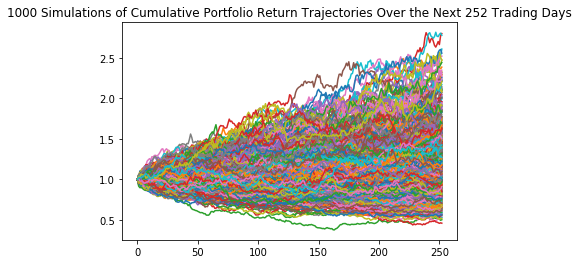

In [11]:
# Use the `plot` function to plot `1000` simulations of the potential trajectories of the portfolio based on 252 trading days
plot_title = f"{n+1} Simulations of Cumulative Portfolio Return Trajectories Over the Next 252 Trading Days"
portfolio_cumulative_returns.plot(legend=None, title=plot_title)

In [12]:
# Select the last row for projecting stock prices (prices of each simulation on the 252nd trading day)
ending_cumulative_returns = portfolio_cumulative_returns.iloc[-1, :]
ending_cumulative_returns.head()

0    1.098082
1    1.723605
2    0.911280
3    1.319448
4    1.137603
Name: 252, dtype: float64

### Plot the Frequency Distribution of Simulated Ending Portfolio Cumulative Returns on the 252nd Trading Day

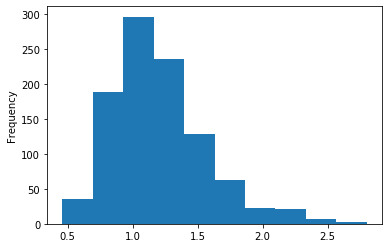

In [13]:
# Use the `plot` function to plot a frequency distribution of simulated ending prices
ending_cumulative_returns.plot(kind='hist', bins=10)

### Calculate the Probability Distribution of Ending Cumulative Return Ranges

In [14]:
ending_cumulative_returns.value_counts(bins=10) / len(ending_cumulative_returns)

(0.928, 1.162]    0.296
(1.162, 1.396]    0.235
(0.694, 0.928]    0.188
(1.396, 1.631]    0.128
(1.631, 1.865]    0.063
(0.456, 0.694]    0.036
(1.865, 2.099]    0.023
(2.099, 2.333]    0.021
(2.333, 2.568]    0.007
(2.568, 2.802]    0.003
Name: 252, dtype: float64

### Calculate Lower and Upper Bounds of 95% Confidence Interval for Simulated Ending Cumulative Portfolio Returns

In [15]:
# Use the `quantile` function to calculate the 95% confidence interval for simulated ending prices
confidence_interval = ending_cumulative_returns.quantile(q=[0.025, 0.975])
confidence_interval

0.025    0.664406
0.975    2.172003
Name: 252, dtype: float64

### Plot the Probability Distribution and 95% Confidence Interval of Simulated Ending Cumulative Portfolio Returns 

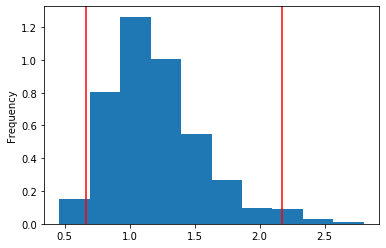

In [16]:
# Use the `plot` function to create a probability distribution histogram of simulated ending prices
# with markings for a 95% confidence interval
plt.figure();
ending_cumulative_returns.plot(kind='hist', density=True, bins=10)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

### Calculate 95% Confidence Interval of An Initial Investment of 10,000 in the Portfolio over the Next 252 Trading Days

In [17]:
# Set initial investment
initial_investment = 10000

# Calculate investment profit/loss of lower and upper bound cumulative portfolio returns
investment_pnl_lower_bound = initial_investment + (initial_investment * confidence_interval.iloc[0])
investment_pnl_upper_bound = initial_investment + (initial_investment * confidence_interval.iloc[1])
                                                    
# Print the results
print(f"There is a 95% chance that an initial investment of $10,000 in the portfolio"
      f" over the next 252 trading days will end within in the range of"
      f" ${investment_pnl_lower_bound} and ${investment_pnl_upper_bound}")

There is a 95% chance that an initial investment of $10,000 in the portfolio over the next 252 trading days will end within in the range of $16644.05777014377 and $31720.033439323197
